In [1]:
import os

import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import get_element, Element
from femsolver.operator import Operator
from femsolver.jax_utils import auto_vmap 
import jax.numpy as jnp
import equinox as eqx

from typing import Callable, Optional, Tuple


import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from femsolver.plotting import STYLE_PATH


In [2]:
def generate_mesh_with_line_elements(
    nx: int,
    ny: int,
    lxs: Tuple[float, float],
    lys: Tuple[float, float],
    curve_func: Optional[Callable[[jnp.ndarray, float], bool]] = None,
    tol: float = 1e-6,
) -> Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray]]:
    """
    Generates a 2D triangular mesh for a rectangle and optionally extracts
    1D line elements along a specified curve.

    Args:
        nx: Number of elements along the x-direction.
        ny: Number of elements along the y-direction.
        lxs: Tuple of the x-coordinates of the left and right edges of the rectangle.
        lys: Tuple of the y-coordinates of the bottom and top edges of the rectangle.
        curve_func: An optional callable that takes a coordinate array [x, y] and
                    a tolerance, returning True if the point is on the curve.
        tol: Tolerance for floating-point comparisons.

    Returns:
        A tuple containing:
        - coords (jnp.ndarray): Nodal coordinates, shape (num_nodes, 2).
        - elements_2d (jnp.ndarray): 2D triangular element connectivity.
        - elements_1d (jnp.ndarray | None): 1D line element connectivity, or None.
    """

    x = jnp.linspace(lxs[0], lxs[1], nx + 1)
    y = jnp.linspace(lys[0], lys[1], ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements_2d = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements_2d.append([n0, n1, n3])
            elements_2d.append([n0, n3, n2])
    elements_2d = jnp.array(elements_2d)

    # --- 2. Extract 1D elements if a curve function is provided ---
    if curve_func is None:
        return coords, elements_2d, None

    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return coords, elements_2d, jnp.array([], dtype=int)

    return coords, elements_2d, jnp.unique(jnp.array(elements_1d), axis=0)

Generated 63 nodes.
Generated 80 2D triangular elements.
Found 15 1D line elements on the curve.


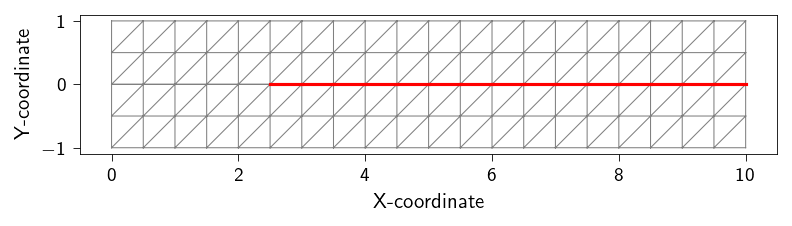

In [3]:
Nx = 20  # Number of elements in X
Ny = 2  # Number of elements in Y
Lx = 10.0  # Length in X
Ly = 1.0  # Length in Y



# function identifies nodes on the cohesive line at y = 0. and x > 2.0
def cohesive_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.logical_and(jnp.isclose(coord[1], 0.0, atol=tol), coord[0] > 2.0)


upper_coords, upper_elements_2d, upper_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(0, Ly), curve_func=cohesive_line
)


lower_coords, lower_elements_2d, lower_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(-Ly, -1e-6), curve_func=cohesive_line
)

coords = jnp.vstack((upper_coords, lower_coords))
elements = jnp.vstack((upper_elements_2d, lower_elements_2d + upper_coords.shape[0]))
lower_elements_1d = lower_elements_1d + upper_coords.shape[0]

print(f"Generated {upper_coords.shape[0]} nodes.")
print(f"Generated {upper_elements_2d.shape[0]} 2D triangular elements.")
print(f"Found {upper_elements_1d.shape[0]} 1D line elements on the curve.")

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)


# Highlight the extracted 1D elements in red
for edge in upper_elements_1d:
    ax.plot(upper_coords[edge, 0], upper_coords[edge, 1], "r-", lw=1.5)
for edge in lower_elements_1d:
    ax.plot(lower_coords[edge, 0], lower_coords[edge, 1], "r-", lw=1.5)

ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect("equal")
plt.show()

To check that the elements along the cohesive line are in same order on both surface, we compare the node values for the two. 

In [4]:
jnp.allclose(coords[upper_elements_1d], coords[lower_elements_1d], atol=1e-6)

Array(True, dtype=bool)

In [5]:
# --- Mesh ---
n_nodes = upper_coords.shape[0]
n_nodes += lower_coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$



In [6]:
class Material(eqx.Module):
    mu: eqx.AbstractVar[float] 
    lmbda: eqx.AbstractVar[float]

In [7]:
# --- Material model (linear elasticity: plane strain) ---
@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def linear_elasticity_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


The femsolver provides a generic class `FemOperator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.

It takes three arguments:

- `compute_quads`: a function that returns the quadrature points and weights for the elements
- `compute_shape_fn`: a function that returns the shape functions for the elements
- `compute_energy`: a function that returns the energy density for the elements


In [8]:
class ElasticityOperator(Operator, Material):
    element: Element
    mu: float
    lmbda: float

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        value = linear_elasticity_energy(u_grad, self.mu, self.lmbda)
        return wi * value * detJ

In [9]:
tri3 = get_element("tri3")
elasticity_op = ElasticityOperator(element=tri3, mu=1.0, lmbda=1.0)


In the above definition of the ``FemOperator`` class, we have used the ``quad_tri3`` and ``shape_fn_tri3`` functions to compute the quadrature points and shape functions for the triangular elements.

One can simply replace these two functions with any other quadrature and shape function. Just look at the ``quad_tri3`` and ``shape_fn_tri3`` functions in ``femsolver/quadrature.py`` to see how to define your own.

For more complex problems, one can define their own implementation of the `FemOperator` class. One just have to inherit from the `FemOperator` class and override the functions that are needed.


Now we prepare the mesh and the boundary conditions and solve the linear elasticity problem.

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{cohesive}(u)$$

The cohesive energy is defined as:

$$\Psi_{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta(\boldsymbol{u})) dA$$

where 

- $\Gamma_{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = \boldsymbol{u}^+ - \boldsymbol{u}^-$ is the displacement jump across the interface.

- $\psi(\boldsymbol{\delta})$ is the cohesive potential, which defines the energy-separation relationship. 

In [10]:
@eqx.filter_jit
def compute_opening(jump_quad: jnp.ndarray, nodes: jnp.ndarray) -> float:
    opening = jump_quad[1]  # we only consider the opening in the y direction
    return opening


@jax.jit
def exponential_cohesive_energy(
    delta: float,
    interface_props: dict[str, float],
    delta_threshold: float = 1e-8,
) -> float:
    delta_c = (interface_props["Gamma"] * jnp.exp(-1)) / interface_props["sigma_c"]

    def true_fun(delta):
        return interface_props["Gamma"] * (
            1 - (1 + (delta / delta_c)) * (jnp.exp(-delta / delta_c))
        )

    def false_fun(delta):
        return 0.5 * interface_props["penalty"] * delta**2

    return jax.lax.cond(delta > delta_threshold, true_fun, false_fun, delta)


class CohesiveProperties(eqx.Module):
    interface_props: eqx.AbstractVar[dict[str, float]]


class CohesiveOperator(Operator, CohesiveProperties):
    element: Element
    interface_props: dict[str, float]

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes) -> float:
        """
        Compute the cohesive energy.
        """
        jump_quad, jump_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        opening_quad = compute_opening(jump_quad, nodes)
        energy = exponential_cohesive_energy(opening_quad, self.interface_props)
        return wi * energy * detJ

We define a new `Line` element to integrate the cohesive energy. The `Line` element is a 1D element that is used to integrate the cohesive energy across the cohesive interface. 

In [11]:
line2 = get_element("line2")
interface_op = CohesiveOperator(
    element=line2, interface_props={"Gamma": 1e-3, "sigma_c": 1e-2, "penalty": 10000.0}
)

Finally, we can put everything together to compute the total energy.

In [12]:
# --- Total energy ---
def _total_energy(
    u_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    elasticity_operator: Operator,
    cohesive_operator: Operator,
    upper_elements: jnp.ndarray,
    lower_elements: jnp.ndarray,
) -> jnp.ndarray:
    """
    Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        elements: Element indices.
        elasticity_operator: ElasticityOperator object.
        cohesive_operator: CohesiveOperator object.
        upper_elements: Indices of the nodes on the upper cohesive surface.
        lower_elements: Indices of the nodes on the lower cohesive surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    elastic_energy = jnp.sum(elasticity_operator.integrate(u_cell, x_cell))

    u_upper = u[upper_elements]    
    u_lower = u[lower_elements]

    # we compute the jump in the displacement field across the cohesive interface
    jump_values = u_upper - u_lower

    # since the two interfaces are identical, we can use the coordinates of the upper interface
    # to intergate and compute the fracture energy
    x_upper_cell = coords[upper_elements]
    
    fracture_energy = jnp.sum(cohesive_operator.integrate(jump_values, x_upper_cell))

    return elastic_energy + fracture_energy

Since in this example, the elements along the cohesive interface (or in the two domains) are pre-determined and the position of the nodes (reference frame) remains the same throughout the simulation, we can use the `eqx.Partial` function to create a partial function that only depends on the displacement field.

In [13]:
total_energy = eqx.filter_jit(eqx.Partial(
    _total_energy,
    coords = coords,
    elements = elements,
    elasticity_operator=elasticity_op,
    cohesive_operator=interface_op,
    upper_elements=upper_elements_1d,
    lower_elements=lower_elements_1d,
))

In [14]:
total_energy(jnp.ones(n_dofs))

Array(0., dtype=float64)

We now locate the dofs in the two domains to apply boundary conditions.

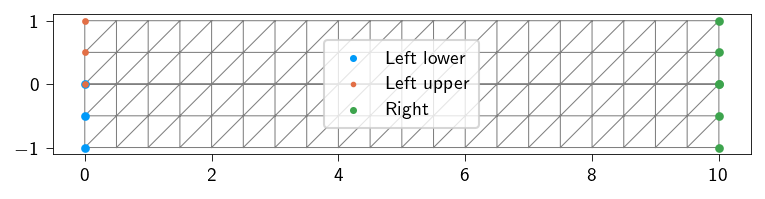

In [15]:

# --- Apply Dirichlet BCs ---
left_upper_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] >= 0))[0]
left_lower_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] < 0))[0]
right_nodes = jnp.where(jnp.isclose(coords[:, 0], Lx))[0]

fixed_dofs = jnp.concatenate(
    [
        2 * right_nodes,
        2 * right_nodes + 1,
        2 * left_upper_nodes + 1,
        2 * left_lower_nodes + 1,

    ]
)

prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * right_nodes + 1].set(0.0)
prescribed_values = prescribed_values.at[2 * left_upper_nodes + 1].set(0.2)
prescribed_values = prescribed_values.at[2 * left_lower_nodes + 1].set(-0.2)

free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


# --- Plot the mesh ---
# We plot the mesh the nodes that are fixed on the left and right edges.

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)

ax.scatter(coords[left_lower_nodes, 0], coords[left_lower_nodes, 1],  s=10, label="Left lower")
ax.scatter(coords[left_upper_nodes, 0], coords[left_upper_nodes, 1],  s=5, label="Left upper")
ax.scatter(coords[right_nodes, 0], coords[right_nodes, 1], s=10, label="Right")
ax.legend()
ax.set_aspect("equal")
ax.legend(loc="center")
plt.show()


In [16]:
# define the displacement field
u = jnp.zeros(n_dofs)

# creating functions to compute the gradient and
# Hessian of the total energy using jax
gradient = jax.grad(total_energy)
hessian = jax.jacfwd(gradient)

# compute the hessian which is the stiffness matrix
# and the gradient which is the internal force vector
K = hessian(u)
f_int = gradient(u)


# --- Solve for the displacement ---
# Ideally we would use a Newton solver to solve for the displacement.
# TODO: Implement a Newton solver.
f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [17]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


In [18]:
grad_us = elasticity_op.gradient(u_full.reshape(-1, n_dofs_per_node)[elements], coords[elements])
strains = compute_strain(grad_us)
stresses = compute_stress(strains, elasticity_op.mu, elasticity_op.lmbda)
stress_vm = von_mises_stress(stresses)

In [19]:
# --- Visualization ---
from femsolver.plotting import STYLE_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()


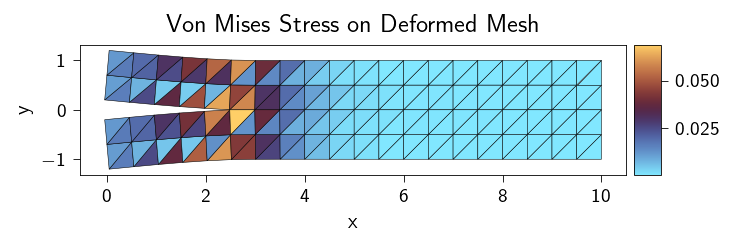

In [20]:
# --- Compute the stress ---    
u = u_full.reshape(-1, n_dofs_per_node)


# --- Plot the displacement and stress ---
plot_displacement_and_stress(coords, u, elements, stress_vm.flatten())

## Assembling mass matrix

The total mass of the system is given as
$$
m = \int \rho  dV
$$


In [26]:
rho = 1.0

class MassOperator(Operator):
    element: Element

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(xi, nodal_values, nodes)
        rho = 1.0
        return wi * rho * u_quad * detJ

In [27]:
mass_op = MassOperator(element=tri3)

In [28]:
def total_mass(
    nodal_values_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    mass_op: Operator,
):
    nodal_values = nodal_values_flat.reshape(-1, n_dofs_per_node)
    return jnp.sum(mass_op.integrate(nodal_values[elements], coords[elements]))

In [29]:
ones = jnp.ones(n_dofs) 
mass_vector = jax.jacrev(total_mass)(ones, coords, elements, mass_op)

### Explicit time integration scheme

We present the explicit time integration scheme based on the Newmark-$\beta$ method.








**Predictor**

$$
u^{0}_{n+1} = u_{n} + \Delta t \dot{u}_{n} + \frac{1}{2} \Delta t^2  \ddot{u}_{n}
$$

$$
\dot{u}^{0}_{n+1} = \dot{u}_{n} + \Delta t \ddot{u}_{n}
$$

$$
\ddot{u}^{0}_{n+1} = \ddot{u}_{n}
$$


**Solve**

$$
\delta \ddot{u} = \frac{1}{\boldsymbol{M}} (f_{\text{ext}, n+1} - f_{\text{int}}(u_{n+1}^{i}) - \boldsymbol{M}\ddot{u}^{i}_{n+1})
$$




**Corrector**

$$
\ddot{u}^{i+1}_{n+1} = \ddot{u}^{i}_{n+1} + \delta\ddot{u}
$$

$$
\dot{u}^{i+1}_{n+1} = \dot{u}^{i}_{n+1} + \frac{1}{2} \Delta t  \delta \ddot{u}^{i+1}_{n+1}
$$




In [30]:
def predictor(u, v, a, dt):
    u_pred = u + dt * v + 0.5 * dt**2 * a
    v_pred = v + dt * a
    a_pred = a
    return u_pred, v_pred, a_pred

def corrector(u_pred, v_pred, a_pred, da, dt):
    a_new = a_pred + da
    v_new = v_pred + 0.5 * dt * da
    return u_pred, v_new, a_new


In [ ]:

dt = 0.8 * h_min / (jnp.sqrt((2 * elasticity_op.mu + elasticity_op.lmbda) / rho))

In [ ]:

dt = 
nsteps = 100
for step in range(n_steps):

    u = u.at[fixed_dofs].set(prescribed_values)
    
    u_pred, v_pred, a_pred = predictor(u, v, a, dt)

    residual = f_ext - f_int(u_pred) - mass_vector @ a_pred

    residual = residual.at[fixed_dofs].set(0)
    da = residual / mass_vector
    
    u, v, a = corrector(u_pred, v_pred, a_pred, da, dt)
    






